In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Yearly interest
r = 0.01
R0 = np.exp(r)

In [11]:
def sample_V(years, sample_size, my, sigma, p, c, yearly_investment=1000):
    frac = lambda k: p*(1-c*(k-1)/30)
    q = np.array([frac(i) for i in range(30)])
    
    Z = pd.DataFrame(np.random.standard_normal(size=(sample_size,years)))
    R1 = np.exp(my + sigma*Z)
    phi = q*(R1 - R0) + R0
    return pd.DataFrame(yearly_investment*phi.sort_index(axis=1,ascending=False).cumprod(axis=1).sum(axis=1))

def sample_V_TI(years, sample_size, r_bar, yearly_investment=1000):
    Z = pd.DataFrame(np.random.standard_normal(size=(sample_size,years)))
    R1 = np.exp(my + sigma*Z)
    G = np.array([yearly_investment*np.exp(r_bar*(j+1)) for j in range(years)]).cumsum()
    phi = (R0-R1)*G*np.exp(-r) + yearly_investment*np.exp(-r)*R1
    
    R1_aug = R1.shift(-1, axis=1)
    R1_aug[years-1] = 1

    return pd.DataFrame((phi * R1_aug.sort_index(axis=1, ascending=False).cumprod(axis=1).sort_index(axis=1)).sum(axis=1))

def emp_dist(x, samples):
    ind = samples < x
    return (ind.sum()/samples.shape[0])[0]

def emp_quantile(p, samples):
    samples = samples.sort_values(by=0)
    #+1 since we want ceil
    ind = int(samples.shape[0]*(1-p) + 1)
    return samples.loc[ind][0]

In [21]:
sample_size = int(1e4)
years = 30
my, sigma = 0.03, 0.2
p, c = 1e-5, 5e-1

V_30 = sample_V(years, sample_size, my, sigma,p, c, yearly_investment=1000)
emp_dist(85*1e3,V_30)
emp_quantile(0.01, V_30)
V_30

,0
0,35161.301479
1,35161.064228
2,35161.276477
3,35161.230443
4,35161.386042
...,...
9995,35161.125765
9996,35161.206319
9997,35161.302966
9998,35161.147032


In [256]:
params = np.random.uniform(size=(10000,2))
sharpe = []
for p,c in params:
    V_30 = sample_V(years, sample_size, my, sigma,p, c, yearly_investment=1000)
    sharpe.append(V_30.mean()/V_30.std())

0.0


<AxesSubplot:ylabel='Frequency'>

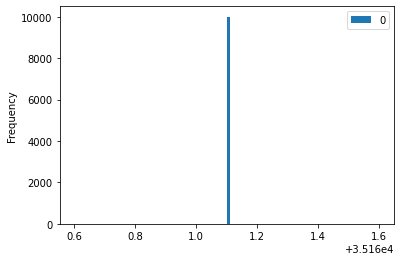

In [307]:
inds = pd.DataFrame(sharpe).sort_values(by=0)[-10:].index
p,c = 0, 0.1 #params[inds][-1]
V_30 = sample_V(years, sample_size, my, sigma,p, c, yearly_investment=1000)
frac = lambda k: p*(1-c*(k-1)/30)
print(frac(30))
V_30.plot.hist(bins=100)

In [69]:
sample_size = int(1e5)
years = 30
r_bar = 0.005
V_30_TI = sample_V_TI(years, sample_size, r_bar)

0    36150.048866
dtype: float64

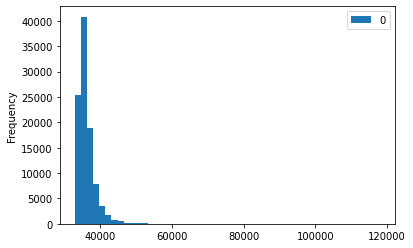

In [70]:
V_30_TI.plot.hist(bins=50)
V_30_TI.mean()

0    35161.261278
dtype: float64

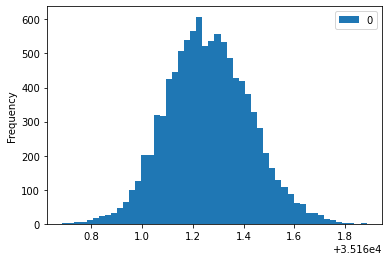

In [26]:
V_30.plot.hist(bins=50)
V_30.mean()

In [71]:
sample_size = int(1e5)
years = 30
r_bar = 0.005
def sample_V_lev(years, sample_size, r_bar, levrage=1, yearly_investment=1000):
    V_list = []
    for i in range(sample_size):
        Z = np.random.standard_normal(size=years)
        R1 = np.exp(my + sigma*Z)
        V = 0
        for i in range(years):
            G = sum([yearly_investment*np.exp(r_bar*(j+1)) for j in range(i+1)])
            V = G*np.exp(-r)*R0 + (V + yearly_investment - G*np.exp(-r))*R1[i]
        V_list.append(V)
    
    return pd.DataFrame(V_list)

<AxesSubplot:ylabel='Frequency'>

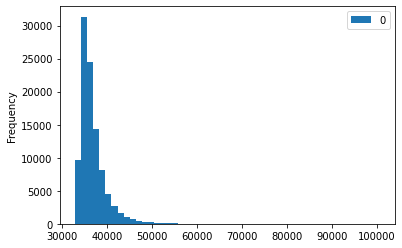

In [72]:
sample_V_lev(years, sample_size, r_bar).plot.hist(bins=50)